## Loading Libraries and Modules

In [1]:
### Loading the main libraries
import sys, os
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook 
from pandas.api.types import is_string_dtype
from sklearn.base import clone 
import eli5
from scipy import stats

#Importing pre-proccesing libraries
from sklearn import model_selection
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline

#Loading latent analysis Models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

#loading classifier models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score,average_precision_score
from eli5.sklearn import PermutationImportance

#Loading regressiom models
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px    

# Disable Printing Function
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore Printing Function
def enablePrint():
    sys.stdout = sys.__stdout__
    
import joblib
import datetime


In [ ]:
#changing default figure renderer for github
import plotly.io as pio
pio.renderers

pio.renderers.default = "svg"

## Defining Classification Functions

In [2]:
###Defining Classifier Regression Functions

def separateData(data,nSplits):
    dummy = data.copy()
    
    ##separating into training and test data
    kfold = model_selection.KFold(n_splits = nSplits, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]] #the tranining set obtained from kfolds
    trainData = train.drop(['Clogged?'],axis=1)
    trainResult = train['Clogged?']
    
    test =  dummy.iloc[result[1]]
    testData = test.drop(['Clogged?'],axis=1)
    testResult = test['Clogged?']

    ##Normalazing data in case we use neural networks
    #nothing 
    #scaler = preprocessing.StandardScaler()  
    scaler = preprocessing.MinMaxScaler() #best
    #scaler = preprocessing.RobustScaler()
    #scaler = preprocessing.Normalizer()
    scaler.fit(trainData)  
    scaled_train = scaler.fit_transform(trainData.values)
    trainData = pd.DataFrame(scaled_train, index=trainData.index, columns=trainData.columns)
    scaled_test = scaler.fit_transform(testData.values)
    testData = pd.DataFrame(scaled_test, index=testData.index, columns=testData.columns)
    
    return trainData, trainResult, testData, testResult, scaler

def separateData_Pipeline(data,nSplits):
    dummy = data.copy()
    
    ##separating into training and test data
    kfold = model_selection.KFold(n_splits = nSplits, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]] #the tranining set obtained from kfolds
    trainData = train.drop(['Clogged?'],axis=1)
    trainResult = train['Clogged?']
    
    test =  dummy.iloc[result[1]]
    testData = test.drop(['Clogged?'],axis=1)
    testResult = test['Clogged?']
    
    return trainData, trainResult, testData, testResult

#trainData, trainResult, testData, testResult  = separateData(apData,5)

def ClassificationModel(model, trainData, trainResult, testData, testResult, printBool):
    mod =  model
    scaler = preprocessing.MinMaxScaler() 
    
    pipeline= Pipeline(steps=[
    ('scaler', scaler),
    ('model', mod),
    ])
    
    mod_pipeline = pipeline.fit(trainData, trainResult)
    prediction = mod_pipeline.predict(testData)
    probs = mod_pipeline.predict_proba(testData)
    probs = probs[:, 1]
    score = mod_pipeline.score(testData,testResult)
    tn, fp, fn, tp = confusion_matrix(testResult,prediction).ravel()
    
    misclassified_samples = testData[testResult != prediction]
    #print(misclassified_samples.index.values)
    #display(misclassified_samples.head())
    #df.index.values
    
    if printBool == True:
        print(type(mod).__name__)
        print("Accuracy:",score)
        print("Precision Score:",average_precision_score(testResult,prediction))
        print("ROC area under curve:", roc_auc_score(testResult,probs))
        #print("\n classification report: \n",classification_report(testResult,prediction))
        print("True Positives:", tp)
        print("False Positives:", fp)  
        print("True Negatives:", tn)
        print("False Negatives:", fn)
        print(confusion_matrix(testResult,prediction),"\n")

    perm = PermutationImportance(mod_pipeline, cv = None, refit = False, n_iter = 50).fit(trainData, trainResult) 
    featureImp = pd.DataFrame(perm.feature_importances_).transpose()
    featureImp.columns = list(testData.columns.values)
    featureImp = featureImp.transpose()
    featureImp.sort_values(0, inplace=True, ascending=False)
    print('Feature Importances:')
    print(featureImp, "\n")
    
    return [score,average_precision_score(testResult,prediction), roc_auc_score(testResult,probs),tp,fp,tn,fn], featureImp , misclassified_samples.index.values

def MultiClassClassificationModel(model, trainData, trainResult, testData, testResult, printBool):
    
    #fitting model
    mod =  model
    mod.fit(trainData,trainResult)
    prediction = mod.predict(testData)
    probs = mod.predict_proba(testData)
    probs = probs[:, 1]
    score = mod.score(testData,testResult)
    t0, f0, ff0, f1, t1, ff1, f2, ff2, t2 = confusion_matrix(testResult,prediction).ravel()
    
    #misclassified_samples = testData[testResult != prediction]
    #print(misclassified_samples.index.values)
    #display(misclassified_samples.head())
    #df.index.values
    total= sum([t0, f0, ff0, f1, t1, ff1, f2, ff2, t2])
    totalFree = sum([t0,f0,ff0])
    totalClogged = sum([t1,f1,ff1])
    totalTransition = sum([t2,f2,ff2])
    
    precisionFree = t0/(t0+f1+f2) #true positive / (true positive + false positive)
    precisionClogged = t1/(t1+f0+ff2) 
    precisionTransition = t2/(t2+ff0+ff1)
    #avgPrecision = (precisionFree*totalFree + precisionClogged*totalClogged + precisionTransition*totalTransition)/(3*total)
    avgPrecision = (precisionFree + precisionClogged + precisionTransition)/(3)
    
    recalFree = t0/(totalFree) # true positive / (true positive + false negative)
    recalClogged = t1/(totalClogged)
    recalTransition = t2/(totalTransition)
    #avgRecal = (recalFree*totalFree + recalClogged*totalClogged + recalTransition*totalTransition)/(3*total)
    avgRecal = (recalFree + recalClogged + recalTransition)/(3)

    
    if printBool == True:
        print(type(mod).__name__)
        print("Accuracy:",score)
        print("Weighted Precision Score:",avgPrecision)
        print("Weighted Recall Score:",avgRecal,'\n')
        print('PrecisionFree:',precisionFree)
        print('PrecisionClogged:',precisionClogged)
        print('PrecisionTransition:', precisionTransition,'\n')
        print('RecallFree:',recalFree)
        print('RecallClogged:',recalClogged)
        print('RecallTransition:', recalTransition,'\n')
        print(confusion_matrix(testResult,prediction),"\n")

    #perm = PermutationImportance(mod, cv = None, refit = False, n_iter = 50).fit(trainData, trainResult) 
    #featureImp = pd.DataFrame(perm.feature_importances_).transpose()
    #featureImp.columns = list(testData.columns.values)
    #featureImp = featureImp.transpose()
    #featureImp.sort_values(0, inplace=True, ascending=False)
    #print('Feature Importances:')
    #print(featureImp, "\n")
    
    return score # average_precision_score(testResult,prediction), roc_auc_score(testResult,probs),tp,fp,tn,fn], featureImp , misclassified_samples.index.values


##Defining Grid Search For Classifiers

def GridSearchClass(model,params, trainData, trainResult, testData, testResult):

    ##Selecting Model and Parameters
    mod = model
    parameter_space = params
   
    #scoring can be "accuracy", "balanced_accuracy","average_precision","roc_auc"
    GS = GridSearchCV(model, parameter_space, scoring= "accuracy", cv=5)#iid = True) #iid = True
    GS.fit(trainData,trainResult)
    bestMod = GS.best_estimator_
    print(bestMod)
    
    ##Finding scoring parameters for best estimator
    score = ClassificationModel(bestMod, trainData, trainResult, testData, testResult,True)
      
## Defining Recursive Feature Elimination Model

def RFEModel(model, nFeatures, trainData, trainResult, testData, testResult):
    mod = model
    rfe = RFE(mod, nFeatures)
    fit = rfe.fit(trainData,trainResult)
    features = fit.n_features_
    ranking = fit.ranking_
    
    featureImp = pd.DataFrame(fit.ranking_).transpose()
    featureImp.columns = list(testData.columns.values)
    featureImp = featureImp.transpose()
    featureImp.sort_values(0, inplace=True, ascending=True)
    print(featureImp)
    

##Defining Function that Checks Best Feature Combinations for Classifiers
def checkFeatureCombinations(model, trainDataC, trainResultC, testDataC, testResultC):
    Testfeatures = list(trainDataC.columns.values)
    Testfeatures.remove("d/D")
    scores = [0,0,0]
    BestScore = 0
    for i in range(len(Testfeatures)):
        for j in range((i+1),len(Testfeatures)):
            for k in range((j+1),len(Testfeatures)):
                prevScores=scores
                features = [Testfeatures[i],Testfeatures[j],Testfeatures[k],"d/D"]
                scores, bestFeaturesMLP = ClassificationModel(model, trainDataC[features], trainResultC, testDataC[features], testResultC, False)
                print(features,scores)
                if sum((scores[0:2]))>BestScore:
                    BestScore = sum((scores[0:2]))
                    bestFeatures = features
                    print(bestFeatures,scores)
                
    return bestFeatures


## Defining Regression Functions

In [3]:
def separateDataReg(data,nSplits,predictedFeature):
    dummy = data.copy()
    
    ##separating into training and test data
    kfold = model_selection.KFold(n_splits = nSplits, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]] #the tranining set obtained from kfolds
    trainData = train.drop([predictedFeature],axis=1)
    trainResult = train[predictedFeature]
    
    test =  dummy.iloc[result[1]]
    testData = test.drop([predictedFeature],axis=1)
    testResult = test[predictedFeature]
    
    ##Normalazing data in case we use neural networks
    #No scaler (best for everything else)
    #scaler = preprocessing.StandardScaler()# (best for MLP)
    #scaler = preprocessing.MinMaxScaler()#  (best for SVR and KKN)
    #scaler = preprocessing.RobustScaler()
    #scaler = preprocessing.Normalizer()
    
    #scaler.fit(trainData)  
    #scaled_train = scaler.fit_transform(trainData.values)
    #trainData = pd.DataFrame(scaled_train, index=trainData.index, columns=trainData.columns)
    #scaled_test = scaler.fit_transform(testData.values)
    #testData = pd.DataFrame(scaled_test, index=testData.index, columns=testData.columns)
    
    return trainData, trainResult, testData, testResult

def RegressionModel(model, trainData, trainResult, testData, testResult):
    mod =  model
    mod.fit(trainData,trainResult)
    prediction = mod.predict(testData)
    score = mod.score(testData,testResult)
    explainedVar = explained_variance_score(testResult,prediction)
    MAE = mean_absolute_error(testResult,prediction)
    print(type(model).__name__)
    print("R^2 Score:", score)
    print("Explained Variance Score:",explainedVar)
    print("Mean Absolute Error:",MAE,'\n')
    
    figure = go.Figure()
    
    figure.add_trace(go.Scatter(x=testResult,y=testResult,mode='lines'))
    figure.add_trace(go.Scatter(x=testResult,y=prediction,mode='markers'))
    
    #figure.update_xaxes(range=[0, 20])
    #figure.update_yaxes(range=[0, 20])

    figure.show(renderer="svg")

    return [score, explainedVar, MAE]

def GridSearchReg(model,params, trainData, trainResult, testData, testResult):

    ##Selecting Model and Parameters
    mod = model
    parameter_space = params
   
    #scoring can be 'r2', ‘neg_mean_absolute_error’, or ‘explained_variance’ 
    GS = GridSearchCV(model, parameter_space, scoring= "r2", cv=5)#, iid = True) #iid = True
    GS.fit(trainData,trainResult)
    bestMod = GS.best_estimator_
    print(bestMod)
    
    ##Finding scoring parameters for best estimator
    score = RegressionModel(bestMod, trainData, trainResult, testData, testResult)


## Other Functions 

In [4]:
##Defining Correlation Data function

def correlationData(data):
    # Look at correlations between features (from precept 6)
    plt.figure(figsize = (5,5), dpi=200)
    plt.matshow(data.corr(), fignum=1, cmap=plt.cm.bwr)
    cols = list(data.columns)
    plt.xticks(list(range(len(cols))), cols, rotation=90)
    plt.yticks(list(range(len(cols))), cols)
    plt.colorbar()
        
#correlationData(apData)

## Defining feature importances by droping collums for random forests
#https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

def dropcol_importances(model, X_train, y_train):
    model_ = clone(model)
    model_.random_state = 999
    model_.fit(X_train, y_train)
    baseline = model_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        model_ = clone(model)
        model_.random_state = 999
        model_.fit(X, y_train)
        o = model_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance',ascending = False)
    return I

##Defining Random Forest Classifier

def RFClassifierDropCol(trainData, trainResult, testData, testResult):
        
    ##Doing Random Forest classifier 
    log = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0,oob_score=True)
    log.fit(trainData,trainResult) 
    prediction = log.predict(testData)
    probs = log.predict_proba(testData)
    probs = probs[:, 1]
    score = log.score(testData,testResult)
    print("Random Forests")
    print("Accuracy:",score)
    print("Precision Score:",average_precision_score(testResult,prediction))
    print("ROC area under curve:", roc_auc_score(testResult,probs))
    print("\n classification report: \n",classification_report(testResult,prediction))
    print(confusion_matrix(testResult,prediction))
    tn, fp, fn, tp = confusion_matrix(testResult,prediction).ravel()
    print("True Negatives:", tn)
    print("False Negatives:", fn)
    print("True Positives:", tp)
    print("False Positives:", fp, "\n")  
    
    #feature importances using Drop Column method
    bestFeaturesDP = dropcol_importances(log, trainData, trainResult)
    
    return [score, average_precision_score(testResult,prediction), roc_auc_score(testResult,probs)], bestFeaturesDP

#scores, bestFeaturesRF = RFClassifierDropCol(apData)

##making function that converts True and False Strings into boolean if neccesary
def makeBoolean(data):
    dummy = data
    if is_string_dtype(data['Clogged?']) == True:
        data["Clogged?"] = data["Clogged?"] == 'TRUE' #or 'True'
    data["Clogged?"]=data["Clogged?"].astype('bool')
    return dummy


##Doing function that rounds to the nearest significant digits
from math import log10, floor 

def roundTo1(x): #1 sig figs
    if x != 0:
        return round(x, -int(floor(log10(abs(x)))))
    else:
        return x
    
def roundTo2(x): #2 sig figs
    if x != 0:
        return round(x, -int(floor(log10(abs(x)))-1))    
    else:
        return x
    
## Defining Function that allows us to visualize the effects of changing variables while 
#  keeping another one constant

def comparingFeatures(targetFeature,targetValue,comparisonFeatures, sigFigs):
      
    roundedData1 = data.copy()
    roundedData1[features] = roundedData1[features].applymap(roundTo1)
    roundedData2 = data.copy()
    roundedData2[features] = roundedData2[features].applymap(roundTo2)
    
    if sigFigs == 1: 
            targetIndeces = roundedData1.index[roundedData1[targetFeature] == targetValue].tolist()
        
    elif sigFigs == 2:
            targetIndeces = roundedData2.index[roundedData2[targetFeature] == targetValue].tolist()
    else:
        print("Choose Either 1 or 2 sig. figs.")
        
    #assemble data set    
    comparisonDataSet = roundedData2.loc[targetIndeces]
    print("Comparison Data Size:", comparisonDataSet.shape)
    
    return comparisonDataSet[comparisonFeatures]

##Defining Features to make decision boundary plots

    
def makeGrid(x, y,nPoints): #h is the spacing between each prediciton
    x_min, x_max = (x.min()-x.max()*0.1), x.max()*1.1 # x.min()-0.03, x.max()+0.03 # 
    y_min, y_max = (y.min()-y.max()*0.1), y.max()*1.1 #y.min()-0.03, y.max()+0.03 #  
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nPoints), np.linspace(y_min, y_max, nPoints))
    return xx, yy

def plotContours(clf, xx, xxT, yy, yyT,colorContour):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
    contour= [go.Contour(z=Z,x=xxT.ravel(),y=yyT.ravel(),colorscale=colorContour,opacity=0.2)]
    return contour
        
def plotDecisionBoundaries(model, feature1, feature2, data, scaled, npoints, colorContour, colorScatter):
    
    #Creating a scaler in case the data has been scaled before (this allows us to un-scale it later)
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(data.drop(['Clogged?'],axis=1))
    
    ##setting up the data for grahps
    trainData, trainResult, testData, testResult, scaler2  = separateData(data,10)        
    classifier = model.fit(trainData[[feature1,feature2]],trainResult) #this is with scaled data
    xx, yy = makeGrid(trainData.loc[:, feature1], trainData.loc[:, feature2],npoints)
        
    if scaled == True: #if the data has been scaled or not
        trainDataT = scaler.inverse_transform(trainData) #inversly scale the data
        trainDataT = pd.DataFrame(trainDataT, index=trainData.index, columns=trainData.columns)
        xxT, yyT = makeGrid(trainDataT.loc[:, feature1], trainDataT.loc[:, feature2],npoints)
        contour = plotContours(classifier, xx, xxT, yy, yyT,colorContour)
        #trainDataT['Clogged?'] = trainResult  
        trainDataT['Clogged?'] = data['Clogged?']  
        scatter2D = px.scatter(trainDataT, x=feature1, y=feature2, color='Clogged?', color_continuous_scale=colorScatter,size='D50')
        #scatter2D = px.scatter(trainDataT, x=feature1, y=feature2,size='D50')
        scatter2D.add_trace(contour[0])
        scatter2D.update_xaxes(showgrid=False, zeroline=False)
        scatter2D.update_yaxes(showgrid=False, zeroline=False)
        scatter2D.show(renderer="svg")
    
    else:
        contour = plotContours(classifier, xx, xx, yy, yy,colorContour)
        #trainData['Clogged?'] = trainResult  
        trainData['Clogged?'] = data['Clogged?']
        scatter2D = px.scatter(trainData, x=feature1, y=feature2, color='Clogged?', color_continuous_scale=colorScatter,size='Throat_Flux')    
        scatter2D.add_trace(contour[0])
        scatter2D.show(renderer="svg")    
    
##making features

def makeFeatures(data,threshold):
    dummy = data
    
    #setup features
    dummy['Particle_Volume'] = (4/3)*3.14159*dummy['Particle_Radius']**3
    dummy['Particle_Mass'] = dummy['Particle_Volume']*3000
    
    #features
    dummy['d/D'] = 2*dummy['Particle_Radius']/dummy['Average_Pore_Size']
    dummy['d/Thickness'] = 2*dummy['Particle_Radius']/dummy['Thickness']
    dummy['d/R'] = 2*dummy['Particle_Radius']/(dummy['Average_Sphere_Radius']*2)
    dummy['D/R'] = dummy['Average_Pore_Size']/(dummy['Average_Sphere_Radius']*2)
    dummy['Thickness/D'] = dummy['Thickness']/dummy['Average_Pore_Size']
    dummy['U_scaled'] =  dummy['Fluid_Velocity']*dummy['d/D']*(1-dummy['Solid_Volume_Fraction'])/ (dummy['Particle_Rate'])
    dummy['AAND'] = dummy['Atom_Atom_CohesiveEnergy']*(3.14159*dummy['Particle_Radius']**2)/(dummy['Particle_Mass']*9.8)
    dummy['AWND'] = dummy['Atom_Wall_CohesiveEnergy']*(3.14159*dummy['Particle_Radius']**2)/(dummy['Particle_Mass']*9.8)
    dummy['Throat_Flux'] = dummy['Particle_Rate']/(1-dummy['Solid_Volume_Fraction']) #particles/(sec)
    dummy['log(nu)'] = np.log10(dummy['nu'])
    dummy['Volume_Fraction'] = 1-dummy['Solid_Volume_Fraction']
    
    #dummy['U_scaled'] =  dummy['Fluid_Velocity']*dummy['Volume_Fraction']/(dummy['Particle_Rate']*dummy['Particle_Radius']*2)
    #dummy['unified'] = (dummy['Particle_Rate']*dummy['Average_Pore_Size']*2)/(2*dummy['Particle_Radius']/dummy['Average_Pore_Size'])
    #dummy['Drag'] = dummy['Fluid_Velocity']**2
    #dummy['AA_Drag'] = dummy['Atom_Atom_CohesiveEnergy']/(1000*(dummy['Fluid_Velocity']**2))
    #dummy['AW_Drag'] = dummy['Atom_Wall_CohesiveEnergy']/(1000*(dummy['Fluid_Velocity']**2))
    

    #end-state characterisation features
    dummy['Umedian/Umean'] = dummy['Umedian']/dummy['Umean']
    #dummy['Throat_Flux'] = dummy['Particle_Rate']*dummy['Average_Pore_Size']/(dummy['Volume_Fraction']) #particles/(throat-sec)

    dummy['EndTime']  = dummy['EndTime']*1e-5
    dummy['ResTime'] = dummy['EndTime']/(0.5/dummy['Fluid_Velocity'])
    
    dummy['U'] = dummy['Fluid_Velocity']/dummy['Average_Pore_Size']
    dummy['D_std'] = dummy['Pore_Size_Std']/dummy['Average_Pore_Size']
    dummy['R_std'] = dummy['Sphere_Radius_Std']/dummy['Average_Pore_Size']
    
    dummy['D10'] = (dummy['Mean_Min_Dist10']/dummy['Particle_Radius']) - 2
    dummy['D25'] = (dummy['Mean_Min_Dist25']/dummy['Particle_Radius']) - 2
    dummy['D33'] = ((dummy['Mean_Min_Dist33']/dummy['Particle_Radius']) - 2) #/(1-dummy['Solid_Volume_Fraction'])
    dummy['D50'] = ((dummy['Mean_Min_Dist50']/dummy['Particle_Radius']) - 2) #/(1-dummy['Solid_Volume_Fraction'])
    dummy['D66'] = (dummy['Mean_Min_Dist66']/dummy['Particle_Radius']) - 2
    dummy['D75'] = (dummy['Mean_Min_Dist75']/dummy['Particle_Radius']) - 2
    dummy['D100'] = (dummy['Mean_Min_Dist100']/dummy['Particle_Radius']) - 2
    
    #dummy['Umean/Uf'] = dummy['Umedian']/(dummy['Fluid_Velocity']+1e-3)
        
    dummy['Clogging_Metric'] = (dummy['D50']*dummy['Umedian/Umean'])**1
    #dummy['Clogging_Metric_2'] = (dummy['D50']*dummy['Umean/Uf'])**1 
    
    #Defining if its clogged or not
    dummy['Clogged?'] = 0
    dummy.loc[(dummy['Clogging_Metric'] <= threshold), 'Clogged?'] = 1 #for clogging metric ^1 use 0.7? or 2.5?
    #dummy.loc[(dummy['Clogging_Metric'] <= 7.5), 'Clogged?'] = True #for clogging metric ^2
    
    
    #other form
    #dummy['Clogged?_2'] = 0
    #dummy.loc[(dummy['Clogging_Metric_2'] <= 2), 'Clogged?_2'] = 1
    
    #dummy.loc[(dummy['test33'] <= 1.75), 'Clogged?'] = True

    #same as excell code: =IF(AND(OR(AC2<0.2,AD2<3.5),AND(AC2<0.75,AD2<100)), TRUE, FALSE)
    #dummy.loc[((dummy['Umedian/Umean'] <= threshold) | (dummy['D33'] <= 3.5)) & ((dummy['Umedian/Umean'] < 0.75) & ((dummy['D33'] <= 100))), 'Clogged?'] = True

    
    ##Doing three posibilities
    #dummy['Clogged?'] = -1 #semi clogged
    #dummy.loc[(dummy['Clogging_Metric'] <= 0.15),'Clogged?'] = 1 #clogged
    #dummy.loc[(dummy['Clogging_Metric'] >= 3),'Clogged?'] = 0 #not clogged
    
    #dummy.loc[((dummy['Umedian/Umean'] <= 0.2) & (dummy['D50'] <= 20)),'Clogged?'] = 1 #clogged
    #dummy.loc[((dummy['Umedian/Umean'] >= 0.6) | (dummy['D50'] >= 60)),'Clogged?'] = 0 #not clogged
    
    return dummy


## Loading, Exploring, and Manipulating Data

In [5]:
###Initializing the data
RvsDvsd = pd.read_csv("Data/sphereSizeVsPoreSizeVsParticleRadius.csv")
ThicknessRatio = pd.read_csv("Data/ratioStudy.csv")
ThicknessRatio2 = pd.read_csv("Data/thicknessRatioStudy.csv")
particleRateData = pd.read_csv("Data/particleRateStudy.csv")
thicknessRatioAndParticleRate = pd.read_csv("Data/ratioStudyParticleRate.csv")
velocitiesAndPoreParticleRatios = pd.read_csv("Data/velocitysPoreSizeVsParticleRatios.csv")
velocityVsPoreRatioVsParticleRate = pd.read_csv("Data/velocityVsPoreRatioVsRate.csv")
constantPoreParticleRatio = pd.read_csv("Data/constantPoreParticleRatio.csv")
sphereRadiusEffects = pd.read_csv("Data/sphereRadiusEffects.csv") 
sphereRadiusStdStudy = pd.read_csv("Data/sphereRadiusStdStudy.csv") 
atomAtomCohesiveStudy = pd.read_csv("Data/atomAtomCohesionStudy.csv")
atomAtomCohesiveStudy2 = pd.read_csv("Data/atomAtomCohesionStudy2.csv")
atomWallCohesiveStudy = pd.read_csv("Data/atomWallCohesionStudy.csv") 
atomWallCohesiveStudy2 = pd.read_csv("Data/atomWallCohesionStudy2.csv") 
bothAtomWallCohesionStudy = pd.read_csv("Data/bothAtomAndWallCohesionStudy.csv") 
viscosityStudy = pd.read_csv("Data/viscosityStudy.csv") 

##Combining the data
data = pd.concat([
                RvsDvsd,
                ThicknessRatio,
                ThicknessRatio2, 
                particleRateData, 
                thicknessRatioAndParticleRate, 
                velocitiesAndPoreParticleRatios, 
                velocityVsPoreRatioVsParticleRate, 
                constantPoreParticleRatio, 
                sphereRadiusEffects,
                sphereRadiusStdStudy, 
                atomAtomCohesiveStudy, 
                atomAtomCohesiveStudy2,
                atomWallCohesiveStudy,
                atomWallCohesiveStudy2,
                bothAtomWallCohesionStudy,
                viscosityStudy
                ],sort=False)

##Making New Features and Cleaning Up
data=makeFeatures(data,1)
data = data.drop(['Unnamed: 0',"Names"],axis=1) #removing the first wierd column
data = data.replace(-1, pd.np.nan).dropna()  #dropping rows with -1 (i.e. error) in their values 
data = data.sort_values('D50',ascending = True) #makes boundaries look good
#data = data.sort_values('Clogging_Metric',ascending = True)
data = data.reset_index(drop=True)
#data.to_csv('data.csv',index=False)

pd.set_option('display.max_columns', None)
#Looking at data
#print("size of data:", data.shape)
display(data.head(n=20))

# Creating a data set made of ONLY A-priori features and Result for Clogging Classifier
postFeatures = ['EndTime','Umedian','Umean','Skew','Kurt','Umedian/Umean','D10','D25','D33','D50','D66','D75',
                'D100','Clogging_Metric','Mean_Min_Dist10','Mean_Min_Dist25','Mean_Min_Dist33','Mean_Min_Dist50',
                'Mean_Min_Dist66','Mean_Min_Dist75','Mean_Min_Dist100','Particle_Mass','Particle_Volume',
                'Average_Pore_Size','Particle_Radius','Thickness','Average_Sphere_Radius','Sphere_Radius_Std',
                'Pore_Size_Std','Fluid_Velocity','Atom_Atom_CohesiveEnergy','Atom_Wall_CohesiveEnergy',
                'Particle_Rate','D_std','R_std',"U","ResTime","Solid_Volume_Fraction",'nu']#,"Umean/Uf",]

apData = data.drop(postFeatures, axis=1)

print("Classifier Data Size:",apData.shape)
display(apData.head())
#apData.to_csv('classifier_data.csv',index=False)

## Creating a data set made of ONLY A-priori features and Result for Regressor
postFeaturesReg = ['EndTime','Umedian','Umean','Skew','Kurt','Umedian/Umean','D10','D25','D33','D50','D66','D75',
                'D100','Clogged?','Mean_Min_Dist10','Mean_Min_Dist25','Mean_Min_Dist33','Mean_Min_Dist50',
                'Mean_Min_Dist66','Mean_Min_Dist75','Mean_Min_Dist100','Particle_Mass','Particle_Volume',
                'Average_Pore_Size','Particle_Radius','Thickness','Average_Sphere_Radius','Sphere_Radius_Std',
                'Pore_Size_Std','Fluid_Velocity','Atom_Atom_CohesiveEnergy','Atom_Wall_CohesiveEnergy',
                'Particle_Rate','D_std','R_std',"U","ResTime","Solid_Volume_Fraction",'nu']#,"Umean/Uf",]

#postFeaturesReg = ['Clogged?','EndTime','Umedian','Umean','Skew','Kurt','Umedian/Umean','D10','D25','D33','D50','D66','D75',
#                'D100','Mean_Min_Dist10','Mean_Min_Dist25','Mean_Min_Dist33','Mean_Min_Dist50',
#                'Mean_Min_Dist66','Mean_Min_Dist75','Mean_Min_Dist100','Particle_Mass','Particle_Volume',
#                'Particle_Radius','ResTime',"UbyFlux"]#"Umean/Uf"]
                #'Average_Pore_Size','Thickness','Average_Sphere_Radius','Sphere_Radius_Std',
                #'Pore_Size_Std','Fluid_Velocity','Atom_Atom_CohesiveEnergy','Atom_Wall_CohesiveEnergy','Particle_Rate'] #,'Distance_Metric','Mean_Min_Dist'] #'Mean_Min_Dist'

apDataReg = data.drop(postFeaturesReg, axis=1)
print("Regression Data Size:",apDataReg.shape)
display(apDataReg.head())
#apDataReg.sample(frac=1).to_csv('regressor_data.csv',index=False)

data.shape

Solid_Volume_Fraction  Average_Pore_Size  Pore_Size_Std  \
0                0.533070           0.004142       0.000943   
1                0.533070           0.004142       0.000943   
2                0.533070           0.004142       0.000943   
3                0.533070           0.004142       0.000943   
4                0.533070           0.004142       0.000943   
5                0.533070           0.004142       0.000943   
6                0.480619           0.005150       0.001308   
7                0.480619           0.005150       0.001308   
8                0.480619           0.005150       0.001308   
9                0.480619           0.005150       0.001308   
10               0.480619           0.005150       0.001308   
11               0.480619           0.005150       0.001308   
12               0.480619           0.005150       0.001308   
13               0.510392           0.005255       0.002417   
14               0.480619           0.005150       0.001308   
15               0.480619           0.005150       0.001308   
16               0.480619           0.005150       0.001308   
17               0.480619           0.005150       0.001308   
18               0.477321           0.005174       0.001522   
19               0.510392           0.005255       0.002417   

    Average_Sphere_Radius  Sphere_Radius_Std  Particle_Radius  Particle_Rate  \
0                0.008593           0.006742          0.00150          12000   
1                0.008593           0.006742          0.00150          12000   
2                0.008593           0.006742          0.00150          12000   
3                0.008593           0.006742          0.00150          12000   
4                0.008593           0.006742          0.00150          12000   
5                0.008593           0.006742          0.00150          12000   
6                0.007843           0.006435          0.00175          10000   
7                0.007843           0.006435          0.00175          10000   
8                0.007843           0.006435          0.00175          10000   
9                0.007843           0.006435          0.00200           5000   
10               0.007843           0.006435          0.00175          10000   
11               0.007843           0.006435          0.00200           5000   
12               0.007843           0.006435          0.00175          10000   
13               0.008697           0.006817          0.00165          10000   
14               0.007843           0.006435          0.00175          10000   
15               0.007843           0.006435          0.00200           5000   
16               0.007843           0.006435          0.00200           5000   
17               0.007843           0.006435          0.00200           5000   
18               0.007411           0.006131          0.00312           1000   
19               0.008697           0.006817          0.00312           1000   

    Atom_Atom_CohesiveEnergy  Atom_Wall_CohesiveEnergy  Thickness       nu  \
0                          0                    500000      0.004  0.00001   
1                          0                    100000      0.004  0.00001   
2                          0                      1000      0.004  0.00001   
3                          0                     50000      0.004  0.00001   
4                          0                      5000      0.004  0.00001   
5                          0                     10000      0.004  0.00001   
6                        100                         0      0.005  0.00001   
7                       1000                         0      0.005  0.00001   
8                       5000                         0      0.005  0.00001   
9                      10000                         0      0.005  0.00001   
10                     10000                         0      0.005  0.00001   
11                      1000                         0      0.0

Classifier Data Size: (2000, 12)


Clogged?       d/D  d/Thickness       d/R       D/R  Thickness/D  U_scaled  \
0         1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   
1         1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   
2         1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   
3         1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   
4         1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   

   AAND         AWND   Throat_Flux  log(nu)  Volume_Fraction  
0   0.0  8503.401361  25699.789418     -5.0          0.46693  
1   0.0  1700.680272  25699.789418     -5.0          0.46693  
2   0.0    17.006803  25699.789418     -5.0          0.46693  
3   0.0   850.340136  25699.789418     -5.0          0.46693  
4   0.0    85.034014  25699.789418     -5.0          0.46693

Regression Data Size: (2000, 12)


d/D  d/Thickness       d/R       D/R  Thickness/D  U_scaled  AAND  \
0  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
2  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
3  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
4  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   

          AWND   Throat_Flux  log(nu)  Volume_Fraction  Clogging_Metric  
0  8503.401361  25699.789418     -5.0          0.46693         0.023606  
1  1700.680272  25699.789418     -5.0          0.46693         0.025230  
2    17.006803  25699.789418     -5.0          0.46693         0.025714  
3   850.340136  25699.789418     -5.0          0.46693         0.029978  
4    85.034014  25699.789418     -5.0          0.46693         0.027422

(2000, 51)

In [6]:
#adding experimental data

#writing data that we would like to make predictions with
col = list(apData.columns)

experimental = [
    
#Agbangla data
[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,1.01E-07,0,0,1.34E+05,-6,2.86E-01],
#[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,1.02E-07,0,0,6.80E+04,-6,2.86E-01],
[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,1.00E-07,0,0,1.41E+04,-6,2.86E-01],
#[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,4.67E-08,0,0,3.00E+04,-6,2.86E-01],
[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,3.01E-08,0,0,2.83E+04,-6,2.86E-01],
[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,1.70E-08,0,0,2.83E+04,-6,2.86E-01],
#[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,1.69E-08,0,0,1.26E+04,-6,2.86E-01],
#[0,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,8.10E-09,0,0,2.71E+04,-6,2.86E-01],
[1,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,4.74E-08,0,0,2.90E+05,-6,2.86E-01],
[1,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,4.72E-08,0,0,1.44E+05,-6,2.86E-01],
#[1,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,1.75E-08,0,0,3.91E+05,-6,2.86E-01],
#[1,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,1.72E-08,0,0,8.04E+04,-6,2.86E-01],
[1,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,8.12E-09,0,0,1.74E+05,-6,2.86E-01],
#[1,0.245,9.80E-02,2.45E-02,1.00E-01,2.50E+00,8.29E-09,0,0,7.86E+05,-6,2.86E-01],
    
#Zurigel pedestrian simulations
[0,5.40E-01,1.08E-01,1.80E-01,3.33E-01,5.00E+00,3.93E-02,0,0,1.65E+01,-10,5.00E-02],
#[0,5.40E-01,1.08E-01,1.80E-01,3.33E-01,5.00E+00,3.93E-02,0,0,2.75E+01,-10,5.00E-02],
#[0,4.50E-01,1.08E-01,1.80E-01,4.00E-01,4.17E+00,3.93E-02,0,0,6.87E+01,-10,6.00E-02],
[0,3.86E-01,1.08E-01,1.80E-01,4.67E-01,3.57E+00,3.93E-02,0,0,5.89E+01,-10,7.00E-02],
[1,5.40E-01,1.08E-01,1.80E-01,3.33E-01,5.00E+00,3.93E-02,0,0,4.12E+01,-10,5.00E-02],
[1,5.40E-01,1.08E-01,1.80E-01,3.33E-01,5.00E+00,3.93E-02,0,0,8.24E+01,-10,5.00E-02],
#[1,4.74E-01,1.08E-01,1.80E-01,3.80E-01,4.39E+00,3.93E-02,0,0,7.23E+01,-10,5.70E-02],
    
#bizmark
[1,0.062,0.062,0.024,3.90E-01,1,5.19E-12,3.49E+09,2.42E+09,1.19E+06,-4.311753861,0.41],
#[1,0.062,0.062,0.024,3.90E-01,1,5.19E-10,3.49E+09,2.42E+09,1.19E+05,-4.311753861,0.41]
    
]

exp_data = pd.DataFrame(np.array(experimental), columns = col)
#exp_data.head(n=16)

apData = apData.append(exp_data)

#apData..sample(frac=1).to_csv('classifier_data.csv',index=False)
apData.shape

(2012, 12)

In [7]:
#test = data[['Names','Clogging_Metric','Clogged?']]
#print(test[test['Names'].str.contains("aaE100000C10000D0.25dRatio")])

#previsou 2 lines same as
#print(data[['Names','Clogging_Metric','Clogged?']][data['Names'].str.contains("aaE100000C10000D0.25dRatio")])

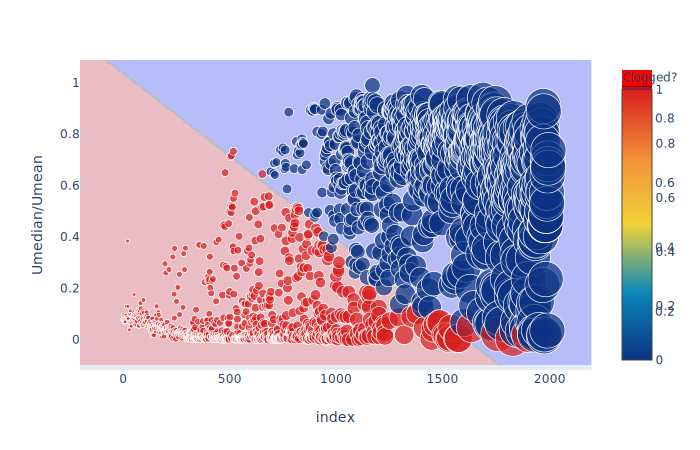

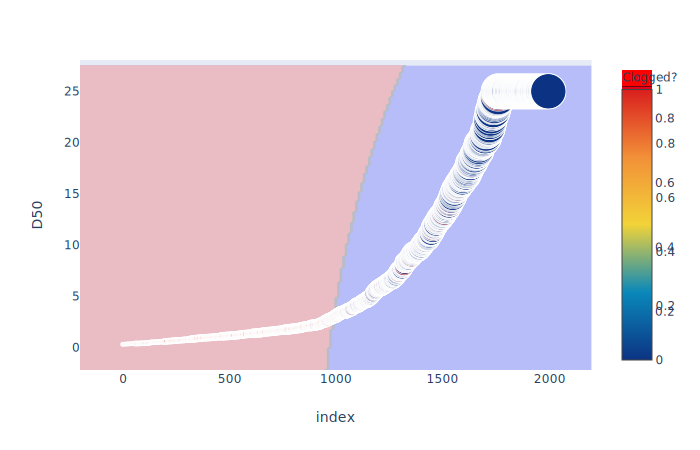

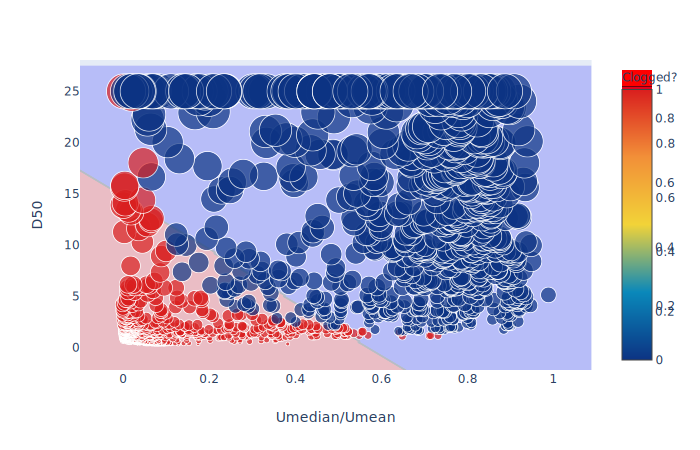

In [8]:
##Ploting Decision Boundaries

#boundFeatures = ['d/Thickness','d/D','Throat_Flux','Fluid_Velocity','Atom_Wall_CohesiveEnergy'] #Features to plot against each other
#boundFeatures = ['nu','d/D'] #Features to plot against each other
boundFeatures = ['Umedian/Umean','D33','D50'] #Features to plot against each other 
data_cut = data
data_cut[data[boundFeatures] > 25] = 25 #Features to plot against each other
#index_names = data[((data['Clogging_Metric'] <= 4.5) & (data['Clogging_Metric'] >= 0.5))].index
#data_cut.drop(index_names, inplace = True) 
boundFeatures = ['index','Umedian/Umean','D50'] #Features to plot against each other 


#Plotting the Contours
for i in range(len(boundFeatures)):
    for j in range((i+1),len(boundFeatures)):
        #plotDecisionBoundaries(ExtraTreesClassifier(n_estimators = 250),boundFeatures[i],boundFeatures[j],data_cut.reset_index(),True,200,'bluered','portland')
        plotDecisionBoundaries(MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
                   hidden_layer_sizes=(175,), learning_rate='adaptive',
                   learning_rate_init=0.001, max_iter=1000, momentum=0.9,
                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                  validation_fraction=0.1, verbose=False, warm_start=False),boundFeatures[i],boundFeatures[j],data_cut.reset_index()
,True,200,'bluered','portland')


In [9]:
#Countour Maps
#den1 = px.density_contour(data.reset_index(), y='D50', x="Umean/Uf",color='Clogged?_2')
#den1.update_traces(contours_coloring="lines", contours_showlabels = True)
#den1.show()

den2 = px.density_contour(data.reset_index(), y='D50', x="Umedian/Umean",color='Clogged?')
den2.update_traces(contours_showlabels = True)
den2.show(renderer="svg")

den3 = px.density_contour(data.reset_index(), y='D50', x="Umedian/Umean",marginal_x="histogram", marginal_y="histogram")
#den3.update_traces(contours_coloring="lines", contours_showlabels = True)
den3.show(renderer="svg")

## Looking at Data and seeing if its linearly separable for Classification

print("True and False Occurances:")
print(data['Clogged?'].value_counts())
print(len(data['D/R'].value_counts())) ##number of different values of X
    
def plotData(data,featureToTest):
    ax = data.astype(float).plot(x=featureToTest, y='Clogged?',style='o',legend='False')
    ax.set_xlabel(featureToTest)
    ax.set_ylabel("Clogged?")

features = list(data.columns.values)
features.remove('Clogged?')

#for feature in features:
#    plotData(data,feature)


## Evaluating Classifiers

In [10]:
##Creating a Data set where 1 feature is held constant 

#targetFeature = 'd/D'   
#targetValue = 0.4
#sigFigs = 1 #1 or 2 sig figs in the target value?
#comparisonFeatures = [targetFeature,'d/Thickness','Thickness/D','Throat_Flux','Clogged?']
#compData = comparingFeatures(targetFeature,targetValue,comparisonFeatures,sigFigs)
#display(compData.head())

#comparisonFeatures.remove('Clogged?')
#for feature in comparisonFeatures:
#        plotData(compData,feature)

In [11]:
##Selecting features to check and creating training and test data sets

display(apData.shape)

#Separate Data Intro Tranining and Testing Data With K-Folds
trainDataC, trainResultC, testDataC, testResultC  = separateData_Pipeline(apData,5)
display(trainDataC.head())

##Defining the Classifiers to Study
Classifiers = [
               #SGDClassifier(max_iter=1000, tol=1e-3, loss = 'log'),
               #LogisticRegression(penalty = "l2",solver='liblinear',max_iter=1000,C=0.1),
               #RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0,oob_score=True),
               #SVC(probability=True, gamma='auto'),
               #KNeighborsClassifier(n_neighbors=5),
               #QuadraticDiscriminantAnalysis(),
               #RidgeClassifier(),
               #BernoulliNB(),
               #BaggingClassifier(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
               #      max_depth=15, max_features='auto', max_leaf_nodes=None,
               #      min_impurity_decrease=0.0, min_impurity_split=None,
               #      min_samples_leaf=1, min_samples_split=2,
               #      min_weight_fraction_leaf=0.0, n_estimators=400,
               #      n_jobs=None, oob_score=False, random_state=32, verbose=0,
               #      warm_start=False)),
               #GradientBoostingClassifier(criterion='friedman_mse', init=None,
               #            learning_rate=0.1, loss='deviance', max_depth=3,
               #            max_features=None, max_leaf_nodes=None,
               #            min_impurity_decrease=0.0, min_impurity_split=None,
               #            min_samples_leaf=1, min_samples_split=2,
               #            min_weight_fraction_leaf=0.0, n_estimators=300,
               #            n_iter_no_change=None, presort='auto',
               #            random_state=32, subsample=1.0, tol=0.0001,
               #            validation_fraction=0.1, verbose=0,
               #            warm_start=False),
               #GaussianProcessClassifier(kernel=RBF(1),random_state=0),
               #AdaBoostClassifier(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
               #    max_depth=20, max_features='auto', max_leaf_nodes=None,
               #    min_impurity_decrease=0.0, min_impurity_split=None,
               #    min_samples_leaf=1, min_samples_split=2,
               #    min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
               #    oob_score=False, random_state=32, verbose=0, warm_start=False)),
               ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                     max_depth=15, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=400,
                     n_jobs=None, oob_score=False, random_state=32, verbose=0,
                     warm_start=False),
               #MLPClassifier(alpha=0.05, hidden_layer_sizes=(125,), random_state=32,
               #    solver='lbfgs'),
               MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
                   hidden_layer_sizes=(175,), learning_rate='adaptive',
                   learning_rate_init=0.001, max_iter=2500, momentum=0.9,
                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                   validation_fraction=0.1, verbose=False, warm_start=False)
               ]

#initializing score and feature matrix
scoresClass = pd.DataFrame(columns = ['Classifier','Accuracy','Precision','ROC',"Tp","Fp","Tn","Fn"])

#Running Classifier Fits and Evaluation Metrics
n=0
bestFeatures={}
indexesMisclass={}
for Class in Classifiers:
    scoresClass.loc[n,'Classifier'] = type(Class).__name__
    scoresClass.loc[n,1:],bestFeatures[type(Class).__name__],indexesMisclass[type(Class).__name__] = ClassificationModel(Class, trainDataC, trainResultC, testDataC, testResultC, True)
    n+=1
    
    #scoresClass.loc[n,'Classifier'] = type(Class).__name__
    #scoresClass.loc[n,1:] = MultiClassClassificationModel(Class, trainDataC, trainResultC, testDataC, testResultC, True)
    #n+=1
    
print(scoresClass)


(2012, 12)

d/D  d/Thickness       d/R       D/R  Thickness/D  U_scaled  AAND  \
0  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
2  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
3  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
4  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   

          AWND   Throat_Flux  log(nu)  Volume_Fraction  
0  8503.401361  25699.789418     -5.0          0.46693  
1  1700.680272  25699.789418     -5.0          0.46693  
2    17.006803  25699.789418     -5.0          0.46693  
3   850.340136  25699.789418     -5.0          0.46693  
4    85.034014  25699.789418     -5.0          0.46693

ExtraTreesClassifier
Accuracy: 0.9652605459057072
Precision Score: 0.942998673316463
ROC area under curve: 0.9942367371065465
True Positives: 198
False Positives: 10
True Negatives: 191
False Negatives: 4
[[191  10]
 [  4 198]] 

Feature Importances:
                        0
d/Thickness      0.173213
d/D              0.134282
Throat_Flux      0.103543
AWND             0.044413
U_scaled         0.039664
d/R              0.020709
AAND             0.020696
log(nu)          0.015836
Thickness/D      0.007632
D/R              0.006190
Volume_Fraction  0.004649 

MLPClassifier
Accuracy: 0.8709677419354839
Precision Score: 0.8209683263250317
ROC area under curve: 0.9361115215999213
True Positives: 178
False Positives: 28
True Negatives: 173
False Negatives: 24
[[173  28]
 [ 24 178]] 

Feature Importances:
                        0
d/R              0.195463
d/Thickness      0.074058
Throat_Flux      0.071896
d/D              0.066961
Volume_Fraction  0.066476
D/R              0.045333
log(nu)

In [12]:
##Looking at the misclassified instances
#print('Misclassified Data Samples:', len(indexesMisclass['ExtraTreesClassifier']))
#display(data.iloc[indexesMisclass['ExtraTreesClassifier']].head(n=20))
#plotDecisionBoundaries(ExtraTreesClassifier(n_estimators = 250),'D50','Umedian/Umean',data.iloc[indexesMisclass['ExtraTreesClassifier']],True,200,'bluered','portland')

display(data.iloc[indexesMisclass['MLPClassifier']].head(n=20))

plotDecisionBoundaries(MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
                   hidden_layer_sizes=(175,), learning_rate='adaptive',
                   learning_rate_init=0.001, max_iter=1000, momentum=0.9,
                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                   validation_fraction=0.1, verbose=False, warm_start=False),'D50','Umedian/Umean',data.iloc[indexesMisclass['MLPClassifier']],True,200,'bluered','portland')


Solid_Volume_Fraction  Average_Pore_Size  Pore_Size_Std  \
23                 0.576620           0.003246       0.001286   
247                0.428334           0.007214       0.001344   
303                0.428334           0.007214       0.001344   
411                0.619828           0.001344       0.001334   
429                0.576620           0.003246       0.001286   
494                0.428334           0.007214       0.001344   
530                0.574247           0.002427       0.000751   
532                0.533070           0.004142       0.000943   
599                0.619828           0.001344       0.001334   
651                0.574247           0.002427       0.000751   
807                0.578684           0.002631       0.000990   
808                0.578684           0.002631       0.000990   
809                0.578684           0.002631       0.000990   
812                0.576620           0.003246       0.001286   
873                0.590945           0.001619       0.001237   
906                0.590945           0.001619       0.001237   
915                0.574247           0.002427       0.000751   
925                0.574247           0.002427       0.000751   
936                0.581924           0.003620       0.002287   
1000               0.428334           0.007214       0.001344   

      Average_Sphere_Radius  Sphere_Radius_Std  Particle_Radius  \
23                 0.007856           0.006333          0.00111   
247                0.008724           0.006897          0.00122   
303                0.008724           0.006897          0.00157   
411                0.009098           0.006917          0.00027   
429                0.007856           0.006333          0.00065   
494                0.008724           0.006897          0.00122   
530                0.007582           0.006148          0.00058   
532                0.008593           0.006742          0.00090   
599                0.009098           0.006917          0.00027   
651                0.007582           0.006148          0.00058   
807                0.008024           0.006410          0.00050   
808                0.008024           0.006410          0.00050   
809                0.008024           0.006410          0.00050   
812                0.007856           0.006333          0.00049   
873                0.007622           0.006018          0.00041   
906                0.007622           0.006018          0.00041   
915                0.007582           0.006148          0.00035   
925                0.007582           0.006148          0.00058   
936                0.009921           0.008161          0.00082   
1000               0.008724           0.006897          0.00192   

      Particle_Rate  Atom_Atom_CohesiveEnergy  Atom_Wall_CohesiveEnergy  \
23             9500                         0                         0   
247           12000                         0                    500000   
303            3000                         0                    500000   
411            8674                    500000                    500000   
429            9500                         0                         0   
494           12000                         0                    100000   
530            2700                         0                   1000000   
532            3000                         0                    500000   
599            2245                    500000                    500000   
651            2700                         0                    650000   
807           10000                    100000                         0   
808           10000                     10000                         0   
809           10000                      1000                         0   
812            9500                         0                         0   
873            9900                         0                         0   
906            3300             

In [13]:
##Doing Grid Search on models
MLPClassParams = {
        'hidden_layer_sizes': [(100,),(125,),(150,),(175,),(200,)],
        'activation': ['logistic','tanh','relu'],
        'solver': ['adam','lbfgs'], #‘sgd’
        'alpha': [0.001,0.005,0.01,0.05,0.1],
        'learning_rate': ['constant','adaptive'],
        }

RFClassParams = {
        'n_estimators' : [5,10,25,100,200],
        'max_depth': [None,2,5,10,20],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4]
        }

ETClassParams = {
        'n_estimators' : [300,375,400,425],
        'max_depth': [None,10,15,20,25],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4],
        'criterion': ['entropy']
        }

KNNClassParams = {
        'n_neighbors' : [21,22,23,24,25,26,27,28,29,30],
        'weights': ['uniform','distance'],
        'algorithm': ['ball_tree','kd_tree','brute'], 
        }

GBClassParams = {
        'loss' : ['deviance'],#,'exponential'],
        'n_estimators' : [100,250,300,350,400],
        'criterion' : ['friedman_mse'],#,'mse','mae']
        #'max_depth': [None,2,5,10,20],
        #'min_samples_split': [2,4,6,8], 
        #'min_samples_leaf': [1,2,4]
        }
BagClassParams = {
        #'loss' : ['deviance'],#,'exponential'],
        'n_estimators' : [10,15,20],
        #'criterion' : ['friedman_mse'],#,'mse','mae']
        #'max_depth': [None,2,5,10,20],
        #'min_samples_split': [2,4,6,8], 
        #'min_samples_leaf': [1,2,4]
        }


#GridSearchClass(MLPClassifier(max_iter=1000,learning_rate = 'adaptive',solver='lbfgs',activation = 'logistic',alpha = 0.05,) 
#                , MLPClassParams, trainDataC, trainResultC, testDataC, testResultC) 

GridSearchClass(MLPClassifier(random_state=32), MLPClassParams, trainDataC, trainResultC, testDataC, testResultC) 

#GridSearchClass(RandomForestClassifier(random_state=32), RFClassParams,trainDataC, trainResultC, testDataC, testResultC) 
#GridSearchClass(ExtraTreesClassifier(random_state=32), ETClassParams, trainDataC, trainResultC, testDataC, testResultC) 
#GridSearchClass(KNeighborsClassifier(),KNNClassParams,trainDataC, trainResultC, testDataC, testResultC) 
#GridSearchClass(GradientBoostingClassifier(random_state=32), GBClassParams,trainDataC, trainResultC, testDataC, testResultC) 

#GridSearchClass(BaggingClassifier(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
#                     max_depth=15, max_features='auto', max_leaf_nodes=None,
#                     min_impurity_decrease=0.0, min_impurity_split=None,
#                     min_samples_leaf=1, min_samples_split=2,
#                     min_weight_fraction_leaf=0.0, n_estimators=400,
#                     n_jobs=None, oob_score=False, random_state=32, verbose=0,
#                     warm_start=False)), BagClassParams,trainDataC, trainResultC, testDataC, testResultC)

#RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#            max_depth=10, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=4,
#            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
#            oob_score=False, random_state=32, verbose=0, warm_start=False)

##Doing RFE on Models
#RFEModel(RFClass, 1, trainDataC, trainResultC, testDataC, testResultC )

C:\Users\Franj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning:

Training interrupted by user.

C:\Users\Franj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning:

Training interrupted by user.



KeyboardInterrupt: 

In [ ]:
##Iteratevily checking best compbination of features (takes a while)

#bestFeaturesMLP = checkFeatureCombinations(MLPClass, trainDataC, trainResultC, testDataC, testResultC)

#checking the results with only X number of features

best = ['D/R']#, 'd/Thickness']#,'Throat_Flux']#, "U_scaled"]#, 'AWND']
#best4FeaturesAllFeatures = ['d/D','Throat_Flux','d/Thickness','AWND','nu','AAND']#,'Throat_Flux','AWND','AAND']#,'nu']
#best4FeaturesRemovedAmbigious =['d/D', 'd/Thickness','Throat_Flux']#,'AWND','AAND','nu'] #'Atom_Wall_CohesiveEnergy']
#best5FeaturesMLP = ['d/D','Throat_Flux','d/Thickness','D/R','Thickness/D']

feat = best #best4FeaturesRemovedAmbigious#best3FeaturesMLP
scoresMLP,bestFeaturesMLP, indexes = ClassificationModel(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=15, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=32, verbose=0, warm_start=False), trainDataC[feat], trainResultC, testDataC[feat], testResultC, True)

#feat = best #best4FeaturesAllFeatures #best4FeaturesRemovedAmbigious#best3FeaturesMLP
#scoresMLP,bestFeaturesMLP, indexes = ClassificationModel(MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
#                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#                   hidden_layer_sizes=(175,), learning_rate='adaptive',
#                   learning_rate_init=0.001, max_iter=1000, momentum=0.9,
#                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
#                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
#                   validation_fraction=0.1, verbose=False, warm_start=False), trainDataC[feat], trainResultC, testDataC[feat], testResultC, True)



## Evaluating Regressors

In [14]:
featuresReg = list(apDataReg.columns.values)
print(featuresReg)

['d/D', 'd/Thickness', 'd/R', 'D/R', 'Thickness/D', 'U_scaled', 'AAND', 'AWND', 'Throat_Flux', 'log(nu)', 'Volume_Fraction', 'Clogging_Metric']


In [15]:
#Selecting features to check
featuresReg = list(apDataReg.columns.values)
#ls = ['d/R','Solid_Volume_Fraction','Particle_Rate']
#ls = ['Particle_Rate','Average_Pore_Size','Thickness','Average_Sphere_Radius','Fluid_Velocity']
#for i in ls:
#    featuresReg.remove(i)

#featuresReg = ['Clogging_Metric','d/D','d/Thickness','AWND','Throat_Flux','UbyFlux']
#featuresReg = ["Solid_Volume_Fraction",'d/R',"AWND",'d/Thickness','Clogging_Metric',"Average_Pore_Size","Fluid_Velocity","Particle_Rate"]

#d/D                       0.262267
#d/R                       0.124594
#AWND                      0.071850
#Throat_Flux               0.063603
#Particle_Rate             0.061406
#d/Thickness               0.055372
#Solid_Volume_Fraction     0.050556

#d/D                       0.287220
#Throat_Flux               0.145785
#d/Thickness               0.087219
#AWND                      0.069422
#Thickness                 0.067323
#R_std                     0.052822
#U                         0.045671

regData = apDataReg[featuresReg]
    #features = ["d/D",'Particle_Rate',"Clogged?"]
    #finalData=apData.drop(['Fluid_Velocity'],axis=1)
    
##removing outliers
#regData = regData[(np.abs(stats.zscore(regData)) < 3).all(axis=1)]

##Separating Data Through K Means
trainDataR, trainResultR, testDataR, testResultR  = separateDataReg(regData.sample(frac=1),5,'Clogging_Metric')
trainResultR = np.log10(trainResultR)
testResultR = np.log10(testResultR)
display(regData.head())


##Defining Regressors to Study

#RFReg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
#           max_features='auto', max_leaf_nodes=None,
#           min_impurity_decrease=0.0, min_impurity_split=None,
#           min_samples_leaf=1, min_samples_split=2,
#           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
#           oob_score=False, random_state=None, verbose=0, warm_start=False)

#MLPReg = MLPRegressor(activation='relu', alpha=0.5, batch_size='auto', beta_1=0.9,
#       beta_2=0.999, early_stopping=False, epsilon=1e-08,
#       hidden_layer_sizes=(100,), learning_rate='adaptive',
#       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
#       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
#       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
#       validation_fraction=0.1, verbose=False, warm_start=False)


ETReg = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False),


Regressors = [
#            LinearRegression(),
#            SVR(),
#            GradientBoostingRegressor(),
#            GaussianProcessRegressor(),
#            KNeighborsRegressor(),
#            TheilSenRegressor(),
#            HuberRegressor(),
#            BaggingRegressor(),
#            AdaBoostRegressor(),
            ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False),
#            ExtraTreesRegressor(max_depth=20, min_samples_split=4, n_estimators=25),
            RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False),
            MLPRegressor(activation='relu', alpha=0.5, batch_size='auto', beta_1=0.9,
                beta_2=0.999, early_stopping=False, epsilon=1e-08,
                hidden_layer_sizes=(100,), learning_rate='adaptive',
                learning_rate_init=0.001, max_iter=1000, momentum=0.9,
                n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                validation_fraction=0.1, verbose=False, warm_start=False)
            ]

#initializing score and feature matrix
scoresReg = pd.DataFrame(columns = ['Regressor','R^2','Explained Variance Score','MAE'])

##Running Fits and Evaluation Metrics
n=0
for Reg in Regressors:
    scoresReg.loc[n,'Regressor'] = type(Reg).__name__
    scoresReg.loc[n,1:] = RegressionModel(Reg, trainDataR, trainResultR, testDataR, testResultR)
    n+=1
    
print(scoresReg)
    

d/D  d/Thickness       d/R       D/R  Thickness/D  U_scaled  AAND  \
0  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
1  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
2  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
3  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   
4  0.724262         0.75  0.174563  0.241022     0.965683  0.000008   0.0   

          AWND   Throat_Flux  log(nu)  Volume_Fraction  Clogging_Metric  
0  8503.401361  25699.789418     -5.0          0.46693         0.023606  
1  1700.680272  25699.789418     -5.0          0.46693         0.025230  
2    17.006803  25699.789418     -5.0          0.46693         0.025714  
3   850.340136  25699.789418     -5.0          0.46693         0.029978  
4    85.034014  25699.789418     -5.0          0.46693         0.027422

ExtraTreesRegressor
R^2 Score: 0.9167967398953856
Explained Variance Score: 0.9168716308054018
Mean Absolute Error: 0.21543833942359358 



RandomForestRegressor
R^2 Score: 0.9142859921118407
Explained Variance Score: 0.9144353205716762
Mean Absolute Error: 0.21247521262353355 



MLPRegressor
R^2 Score: -33.00565044650184
Explained Variance Score: -32.91919215648378
Mean Absolute Error: 2.7039305051186466 



               Regressor       R^2 Explained Variance Score       MAE
0    ExtraTreesRegressor  0.916797                 0.916872  0.215438
1  RandomForestRegressor  0.914286                 0.914435  0.212475
2           MLPRegressor  -33.0057                 -32.9192   2.70393


## Performing Grid Search on Regressors

MLPRegParams = {
        'hidden_layer_sizes': [(275,),(400,),(500,),(600,),(700,)],
        #'activation': ['logistic','tanh'], #'relu'
        #'solver': ['adam','lbfgs','sgd'], #‘sgd’
        #'alpha': [0.475,0.5,0.525,]
        #'learning_rate': ['constant','adaptive'],
        }

RFRegParams = {
        'n_estimators' : [5,10,25,100,200],
        'max_depth': [None,2,5,10,20],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4]
        }

ETRegParams = {
        'n_estimators' : [23,24,25,26,27],
        'max_depth': [None,2,5,10,20],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4]
        }

#GridSearchReg(MLPRegressor(max_iter=1000, learning_rate = 'adaptive', solver = 'lbfgs', alpha=0.5), MLPRegParams, trainDataR, trainResultR, testDataR, testResultR) 
#GridSearchReg(RandomForestRegressor(),RFRegParams, trainDataR, trainResultR, testDataR, testResultR) 
GridSearchReg(ExtraTreesRegressor(),ETRegParams, trainDataR, trainResultR, testDataR, testResultR) 

##Performing RFE on Regressors

#RFEModel(ETReg, 1, trainDataC, trainResultC, testDataC, testResultC )



In [ ]:
#Feature importance:

ETR = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False)

top = trainDataR.columns# ['D/R','d/Thickness','Throat_Flux',"U_scaled", 'AWND']

ETR.fit(trainDataR[top], trainResultR)
prediction = ETR.predict(testDataR[top])
score = ETR.score(testDataR[top],testResultR)
featureImp = pd.DataFrame(ETR.feature_importances_).transpose()
featureImp.columns = list(trainDataR[top].columns.values)
featureImp = featureImp.transpose()
featureImp.sort_values(0, inplace=True, ascending=False)
print(score)
print(featureImp)

# Saving the Model and Data

In [ ]:
import joblib

#Training Best Classifier

scaler_C = preprocessing.MinMaxScaler() 

#MLP = MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
#                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#                   hidden_layer_sizes=(175,), learning_rate='adaptive',
#                   learning_rate_init=0.001, max_iter=2500, momentum=0.9,
#                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
#                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
#                   validation_fraction=0.1, verbose=False, warm_start=False)

MLP = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                     max_depth=15, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=400,
                     n_jobs=None, oob_score=False, random_state=32, verbose=0,
                     warm_start=False)


pipeline= Pipeline(steps=[
    ('scaler', scaler_C),
    ('model', MLP),
])

##training on whole data set (as it should be)
MLP_Pipeline = pipeline.fit(apData.drop(["Clogged?"],axis=1), apData["Clogged?"])

#Training Best Regressor

ETR = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False)

##training on whole data set (as it should be)
ETR.fit(regData.drop(["Clogging_Metric"],axis=1), regData["Clogging_Metric"])

#exporting models
MLP_filename = 'Classifier_Model_All_Features_new.joblib'
ETR_filename = 'Regression_Model_All_Features_new.joblib'
joblib.dump(MLP_Pipeline,'BigQuery/Classifier_Model/' + MLP_filename)
joblib.dump(ETR,'BigQuery/Regressor_Model/' + ETR_filename)

In [ ]:
# training top 5 features

top = ['d/Thickness','d/D','Throat_Flux','AWND','U_scaled']

#Training Best Classifier

scaler_C = preprocessing.MinMaxScaler() 

#MLP = MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
#                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#                   hidden_layer_sizes=(175,), learning_rate='adaptive',
#                   learning_rate_init=0.001, max_iter=2500, momentum=0.9,
#                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
#                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
#                   validation_fraction=0.1, verbose=False, warm_start=False)

MLP = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                     max_depth=15, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=400,
                     n_jobs=None, oob_score=False, random_state=32, verbose=0,
                     warm_start=False)


pipeline= Pipeline(steps=[
    ('scaler', scaler_C),
    ('model', MLP),
])

##training on whole data set (as it should be)
MLP_Pipeline = pipeline.fit(apData[top], apData["Clogged?"])

#Training Best Regressor

ETR = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False)

##training on whole data set (as it should be)
ETR.fit(regData[top], regData["Clogging_Metric"])

#exporting models
MLP_filename = 'Classifier_Model_5_Features_new.joblib'
ETR_filename = 'Regression_Model_5_Features_new.joblib'
joblib.dump(MLP_Pipeline,'BigQuery/Classifier_Model/' + MLP_filename)
joblib.dump(ETR,'BigQuery/Regressor_Model/' + ETR_filename)

In [ ]:
regData.head()

In [ ]:
trainData_R[["AWND","U_scaled"]].describe()

In [ ]:
#export large json file with 100 instances:

f = open("BigQuery/input_C.json", "w")

for row in testData_C.tail(n=5).iterrows():
    row[1].to_json(f, orient="values")
    f.write("\n")
    
f.close()

f1 = open("BigQuery/input_R.json", "w")

for row in testData_R.tail(n=5).iterrows():
    row[1].to_json(f1, orient="values")
    f1.write("\n")
    
f1.close()

open("BigQuery/input_C.json").read()
open("BigQuery/input_R.json").read()


In [ ]:
testResult_R.tail(n=5)

# Bar Graph Plotting 

In [ ]:
dimensions = {"height" : 600, "width" :1000}
gridTemplate = {"showgrid":False, "showline":True, "linecolor":"black", "linewidth":1, "ticks":'outside'}

x = ['$\large d/D$', '$\large d/T$', '$\large F_{nd}$',
     '$\large {PW}_{nd} $', '$\large {PP}_{nd} $', '$\large \nu $']

y1 = [0.18, 0.17, 0.14, 0.06, 0.02, 0.02]
y1_s = [0.52, 0.58, 0.88, 0.90, 0.92, 0.93]# np.round(y1, decimals=2)
y_perm = np.round([i * 1 for i in y1],decimals=3)
#y_perm = [i * 2.2e-13 for i in y1]


trace1 = go.Bar(
    x=y1,
    y=x,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    orientation='h',
)

fig = go.Figure(data = [trace1])

fig.update_layout(
    yaxis=dict(
        showgrid=True,
        showline=True,
        showticklabels=True,
        domain=[0, 1],
    ),
    xaxis=dict(
        zeroline=True,
        showline=True,
        showticklabels=True,
        showgrid=True,
        title = "Normalized Feature Importance",
        domain=[0, 1],
        tick0 = 0,
        dtick = 0.05,
        tickson="boundaries",

    ),
    legend=dict(x=0, y=1.038, font_size=14),
    #margin=dict(l=100, r=100, t=70, b=70),
    font = dict(size = 14),
    #autosize =True,
    paper_bgcolor='white',#'rgb(248, 248, 255)',
    plot_bgcolor='white',#'rgb(248, 248, 255)',
)


fig.update_layout(
    title={
        'text': "Feature Importance Rankings",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

annotations = []

for ya, yd, xd, perm in zip(y1, y1_s, x, y_perm):
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=ya + 0.01,
                            text=str(yd) + '%',
                            font=dict(family='Arial', size=14,
                                      color='Black'),#'rgb(50, 171, 96)'),
                            showarrow=False))
    
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=ya - 0.005,
                            text=str(perm),
                            font=dict(family='Arial', size=14,
                                      color='Black'),#'rgb(50, 171, 96)'),
                            showarrow=False))
    
fig.update_layout(annotations=annotations)
fig.update_xaxes(gridTemplate,automargin=True)# range = [0,1.7])
fig.update_yaxes(autorange="reversed")
fig.update_layout(dimensions)
fig.show()

fig.write_image("bar.png",scale=2)


## LDA Analysis

## Representative Graphs

In [ ]:
# 2D graphs
scatter2D = px.scatter(data.reset_index(), x='d/D', y='Throat_Flux',color='Clogged?',color_continuous_scale='temps')    
scatter2D.show()

scatter2D = px.scatter(data.reset_index(), x='AWND', y='d/D',color='Clogged?',color_continuous_scale='temps',size='Throat_Flux')    
scatter2D.update_xaxes(range=[0, 50000])
scatter2D.show()

In [ ]:
scatter3D = px.scatter_3d(data.reset_index(), x='AWND', y="Throat_Flux", z = 'd/D', color='Clogged?',color_continuous_scale='temps',log_x=True)   
scatter3D.update_xaxes(range=[0, 10000])
scatter3D.show()

In [ ]:
##Exploring Data Templates to Use:

scatter2D = px.scatter(data.reset_index(), x='index', y="Umedian/Umean",color='Clogged?',color_continuous_scale='temps',size='Throat_Flux')    
scatter2D.show()

den = px.density_contour(data.reset_index(), x='index', y="Umedian/Umean")
den.update_traces(contours_coloring="fill", contours_showlabels = True)
den.show()

scatter2D = px.scatter(data.reset_index(), y='D50', x="Umedian/Umean",color='Clogged?',color_continuous_scale='temps',size='Throat_Flux')    
scatter2D.show()

den = px.density_contour(data.reset_index(), y='D50', x="Umedian/Umean",color='Clogged?')
den.update_traces(contours_coloring="lines", contours_showlabels = True)
den.show()


scatter3D = px.scatter_3d(data.reset_index(), x='index', y="Umedian/Umean", z = 'd/D', color='Clogged?',color_continuous_scale='temps',size='Throat_Flux')   
scatter3D.show()

scatterMat = px.scatter_matrix(classData.reset_index(), dimensions = list(classData.drop(['Clogged?'],axis=1).columns.values), color= 'Clogged?', color_continuous_scale='temps' )
scatterMat.show()

parGraph = px.parallel_coordinates(classData.reset_index(), dimensions = list(classData.drop(['Clogged?'],axis=1).columns.values), color= 'Clogged?', color_continuous_scale='temps')
parGraph.show()

ternary = px.scatter_ternary(data.reset_index(), a="d/D", b="Throat_Flux", c="Umedian/Umean", color="Clogged?", size="Clogging_Metric", size_max=15, color_continuous_scale='temps')
ternary.show()

#coool color schemes: 'portland','temps','redblue','tealrose'
# add extra rows or columns of grahps : ... facet_col='Particle_Rate',facet_row = 'nu')


In [ ]:
from platform import python_version
import sklearn

print(python_version())

print('The scikit-learn version is {}.'.format(sklearn.__version__))
